# Purpose:
This notebook aims to use 311 Data to:
1. Segment by neighborhood and department
2. Create a time series prediction for 311 request volume using FB Prophet

In [3]:
import pandas as pd

df = pd.read_pickle('hood_census_sample.pkl')

In [4]:
df.CREATED_DATE = df.CREATED_DATE.apply(lambda x: pd.to_datetime(x))
df.to_pickle('hood_census_sample2.pkl')

In [5]:
df

,Unnamed: 0,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,OWNER_DEPARTMENT,STATUS,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,STREET_ADDRESS,...,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,COMPLETION_TIME,LOCATION2,NEIGHBORHOOD,CENSUS_TRACT
0,868388,SR19-02704231,Sign Repair Request - All Other Signs,PCE,CDOT - Department of Transportation,Completed,2019-10-11,10/11/2019 11:06:30 AM,2019-10-11,177 E GARFIELD BLVD,...,10,1.178423e+06,1.868443e+06,41.794324,-87.621265,"(41.79432382196822, -87.6212650519003)",0.0,"(-87.62126505200001, 41.794323821999996)",WASHINGTON PARK,4005
1,2516264,SR19-00137226,Alley Pothole Complaint,PHB,CDOT - Department of Transportation,Completed,2019-01-30,02/13/2020 06:30:55 PM,2019-04-26,3700 N OSCEOLA AVE,...,1,1.125681e+06,1.923635e+06,41.946813,-87.813447,"(41.94681323532163, -87.81344676709838)",86.0,"(-87.813446767, 41.946813235)",DUNNING,1704
2,2463123,SR20-03439197,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2020-02-01,02/04/2020 10:15:49 AM,2020-02-04,5212 N KENNEDY FOSTER AV ER,...,2,1.136877e+06,1.934370e+06,41.976077,-87.772033,"(41.97607693788143, -87.77203338518417)",3.0,"(-87.772033385, 41.976076938)",JEFFERSON PARK,1104
3,1258368,SR19-00600860,Weed Removal Request,SCP,Streets and Sanitation,Completed,2018-07-27,02/13/2020 08:26:29 PM,2018-07-27,1450 S SPAULDING AVE,...,7,1.154078e+06,1.909655e+06,41.907931,-87.709440,"(41.9079306406455, -87.70943987318603)",0.0,"(-87.709439873, 41.907930641)",HUMBOLDT PARK,2309
4,1745984,SR19-01616432,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2019-06-03,02/14/2020 12:31:27 AM,2019-06-04,2441 W LOGAN BLVD,...,6,1.159438e+06,1.917095e+06,41.928240,-87.689545,"(41.92823971457503, -87.68954547516664)",1.0,"(-87.689545475, 41.928239715)",LOGAN SQUARE,8309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204498,851044,SR19-02700011,Aircraft Noise Complaint,AVN,Aviation,Completed,2019-10-10,10/10/2019 08:31:49 PM,2019-10-10,10510 W ZEMKE RD,...,10,1.105376e+06,1.941043e+06,41.994897,-87.887752,"(41.9948965489749, -87.8877516541201)",0.0,"(-87.887751654, 41.994896549)",OHARE,9800
204499,2552115,SR20-03389574,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2020-01-24,01/28/2020 04:47:15 PM,2020-01-28,9944 S HALSTED ST,...,1,1.172728e+06,1.838715e+06,41.712872,-87.643024,"(41.71287202787818, -87.64302389465593)",4.0,"(-87.643023895, 41.712872028)","WASHINGTON HEIGHTS,ROSELAND",7306
204500,351970,SR19-01951503,Weed Removal Request,SCP,Streets and Sanitation,Completed,2019-07-15,07/15/2019 03:08:05 PM,2019-07-15,7120 S RHODES AVE,...,7,1.181059e+06,1.857818e+06,41.765106,-87.611926,"(41.76510582750071, -87.61192567443094)",0.0,"(-87.61192567399998, 41.765105828)","SOUTH SHORE, GRAND CROSSING",6909
204501,3546142,SR20-04691684,Tree Removal Request,SEE,Streets and Sanitation,Open,2020-07-29,07/29/2020 09:01:16 AM,NaN,5343 W WARNER AVE,...,7,1.139797e+06,1.926986e+06,41.955764,-87.761478,"(41.95576394427719, -87.76147791838466)",NaN,"(-87.761477918, 41.955763944)",PORTAGE PARK,1503


### Groupby Neighborhoods

In [6]:
df.groupby('NEIGHBORHOOD')['SR_TYPE'].count().sort_values(ascending = False).index[:10]

Index(['OHARE', 'ENGLEWOOD', 'WASHINGTON HEIGHTS,ROSELAND',
       'IRVING PARK,AVONDALE', 'MARQUETTE PARK,GAGE PARK',
       'SOUTH SHORE, GRAND CROSSING', 'AUSTIN', 'BRIGHTON PARK,MCKINLEY PARK',
       'MIDWAY AIRPORT', 'HUMBOLDT PARK'],
      dtype='object', name='NEIGHBORHOOD')

In [7]:
df.OWNER_DEPARTMENT.unique()

array(['CDOT - Department of Transportation', 'Streets and Sanitation',
       'Aviation', 'DOB - Buildings',
       'DWM - Department of Water Management'], dtype=object)

### turn data into time-series format

In [8]:
df.CREATED_DATE
#set this column to index and then resample
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

#now create time series for each type of neighborhood, let's just try with 1 neighborhood first

df_test = pd.DataFrame(df[(df.NEIGHBORHOOD == 'WICKER PARK,WEST TOWN') & (df.OWNER_DEPARTMENT == 'Streets and Sanitation')]
                       .groupby(['CREATED_DATE'])['Unnamed: 0'].count()).reset_index()

#df_test = pd.DataFrame(df.CREATED_DATE, df.NEIGHBORHOOD)
#df_test.loc[:, ['CREATED_DATE', ]]
df_test = df_test.set_index('CREATED_DATE').resample('D').first()
df_test.fillna(0, inplace = True)
display(df_test['Unnamed: 0'].value_counts())
d = {'ds': df_test.index, 'y': df_test['Unnamed: 0']}
time_series_df = pd.DataFrame(data = d).dropna()
#time_series_df = time_series_df.set_index('CREATED_DATE')#.resample(rule = '4T', on = 'CREATED_DATE')
time_series_df

1.0     175
0.0     141
2.0     128
3.0     115
4.0      78
5.0      57
6.0      35
7.0      23
8.0      19
9.0       7
10.0      6
11.0      6
12.0      2
16.0      1
Name: Unnamed: 0, dtype: int64

,ds,y
CREATED_DATE,,
2018-07-01,2018-07-01,2.0
2018-07-02,2018-07-02,8.0
2018-07-03,2018-07-03,6.0
2018-07-04,2018-07-04,1.0
2018-07-05,2018-07-05,7.0
...,...,...
2020-08-27,2020-08-27,1.0
2020-08-28,2020-08-28,6.0
2020-08-29,2020-08-29,4.0


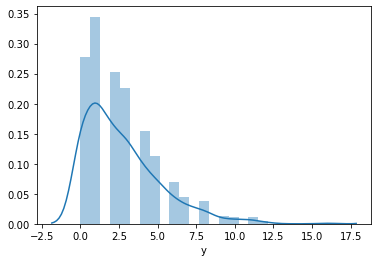

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(time_series_df.y)

#make datetime index, resample on a daily basis

# Use FB Prophet to Create ML Time Series Predictions 

In [10]:
from fbprophet import Prophet

model = Prophet()

model.fit(time_series_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = model.make_future_dataframe(periods=365)
future.shape

(1158, 1)

In [12]:
future[future.ds>'2020-08-31']

,ds
793,2020-09-01
794,2020-09-02
795,2020-09-03
796,2020-09-04
797,2020-09-05
...,...
1153,2021-08-27
1154,2021-08-28
1155,2021-08-29
1156,2021-08-30


In [13]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1153,2021-08-27,4.566517,1.978047,7.191238
1154,2021-08-28,2.747128,0.363394,5.238143
1155,2021-08-29,2.979522,0.278035,5.556768
1156,2021-08-30,5.370662,2.695238,7.880637
1157,2021-08-31,5.438111,2.847873,8.019503


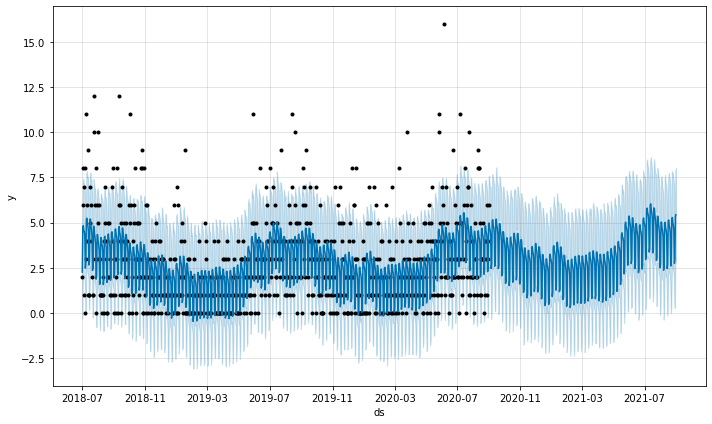

In [14]:
#interpretation of these forecasts
#limiting scope
#

fig1 = model.plot(forecast)

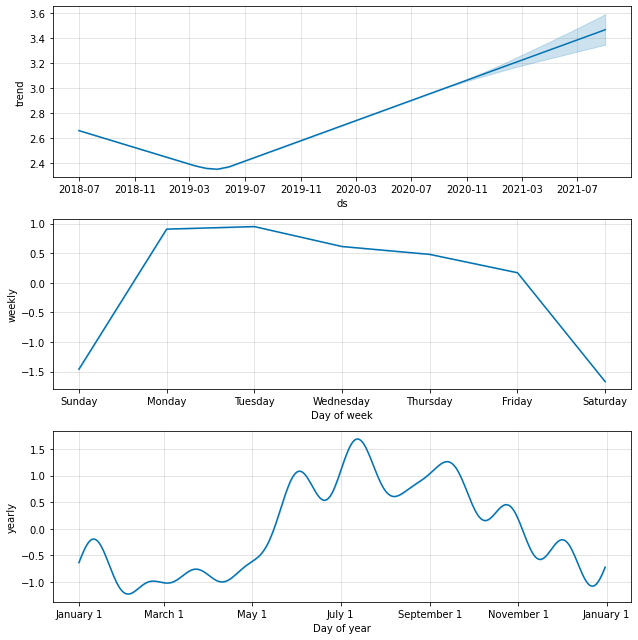

In [15]:
fig2 = model.plot_components(forecast)

# Create definition to make time series forecast for specific neighborhood and department

In [16]:
#create time series for each neighborhood or department
#create tool where you put in your neighborhood, department, time period
#returns forecast + graph for specified time period
#returns total number of predicted values for time period

def create_time_series(neighborhood, department, days):
    df_test = pd.DataFrame(df[(df.NEIGHBORHOOD == neighborhood) & (df.OWNER_DEPARTMENT == department)]
                       .groupby(['CREATED_DATE'])['Unnamed: 0'].count()).reset_index()

    df_test = df_test.set_index('CREATED_DATE').resample('D').first()
    df_test.fillna(0, inplace = True)
    d = {'ds': df_test.index, 'y': df_test['Unnamed: 0']}
    time_series_df = pd.DataFrame(data = d).dropna()
    model = Prophet()
    model.fit(time_series_df)
    future = model.make_future_dataframe(periods=days)
    forecast = model.predict(future)
    f = {'Dates' : forecast.ds, 'Predicted Number of Service Calls' : forecast.yhat}
    return pd.DataFrame(data = f)

create_time_series('OHARE', 'Streets and Sanitation', 365)
    
#fit model to cross validation and figure out accuracy, at the very least look at prophet metrics functionality

#draw error bar around linegraph too, look into error bar

#if they were to use this tool would it reduce completion time?

#look at completion times during peak periods vs completion times during other months - 
#this can tell us if there's a pile up

#was prophet able to idnetify seasonality / trend and maybe we can help allocate resources better

#are the numbers growing? 

#look at seasonality / trends per neighborhood, for chicago overall, think about what I would tell city of chicago 

#tool is 1 part but we need more EDA to introduce project questions / patterns introducing question

#problem is there's a lot of service requests, they take a long time to fill, but why? what layers are beneath it
#think of what recommendations you'd have for this department

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Dates,Predicted Number of Service Calls
0,2018-07-13,0.310868
1,2018-07-14,0.214580
2,2018-07-15,0.206997
3,2018-07-16,0.288333
4,2018-07-17,0.314689
...,...,...
1135,2021-08-21,0.122559
1136,2021-08-22,0.116100
1137,2021-08-23,0.199403
1138,2021-08-24,0.228554


In [17]:
#look for spikes in 311 service call volume

#projected line graph of volume